In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# **NER USING BERT**

## The goal of a named entity recognition (NER) system is to identify all textual mentions of the named entities. This can be broken down into two sub-tasks: identifying the boundaries of the NE, and identifying its type.

Named entity recognition is a task that is well-suited to the type of classifier-based approach. In particular, a tagger can be built that labels each word in a sentence using the IOB format, where chunks are labelled by their appropriate type.

The IOB Tagging system contains tags of the form:

B - {CHUNK_TYPE} – for the word in the Beginning chunk
I - {CHUNK_TYPE} – for words Inside the chunk
O – Outside any chunk
The IOB tags are further classified into the following classes –

geo = Geographical Entity
org = Organization
per = Person
gpe = Geopolitical Entity
tim = Time indicator
art = Artifact
eve = Event
nat = Natural Phenomenon

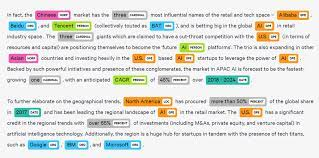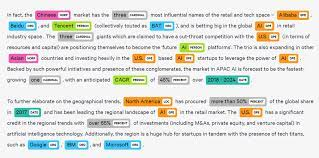

**Something Like This** ⬆️

# **Connecting To TPU**

In [ ]:
import tensorflow  as tf
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

# **Importing Required Libraries**

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping


import transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# **Loading Dataset**

In [ ]:
dataframe = pd.read_csv("/projects/0/prjs0809/Daniel/DSP/data/ner_dataset.csv",encoding = 'ISO-8859-1',error_bad_lines = False)
dataframe = dataframe.dropna()
dataframe.head()

In [ ]:
dataframe.Tag.unique()
print(f"Number of Tags : {len(dataframe.Tag.unique())}")

# Exploratory Data Analysis 

In [ ]:
pie = dataframe['Tag'].value_counts()
px.pie(names = pie.index,values= pie.values,hole = 0.5,title ='Total Count of Tags')

In [ ]:
bar = dataframe['POS'].value_counts()
px.bar(x = bar.index,y = bar.values,title = "Total Count of Parts of Speech",color = bar.index)

# **Grouping, Tokenizing and Padding**

In [ ]:
dataframe["Sentence #"] = dataframe["Sentence #"].fillna(method="ffill")
sentence = dataframe.groupby("Sentence #")["Word"].apply(list).values
pos = dataframe.groupby(by = 'Sentence #')['POS'].apply(list).values
tag = dataframe.groupby(by = 'Sentence #')['Tag'].apply(list).values

In [ ]:
def process_data(data_path):
    df = pd.read_csv(data_path, encoding="latin-1")
    df.loc[:, "Sentence #"] = df["Sentence #"].fillna(method="ffill")

    enc_pos = preprocessing.LabelEncoder()
    enc_tag = preprocessing.LabelEncoder()

    df.loc[:, "POS"] = enc_pos.fit_transform(df["POS"])
    df.loc[:, "Tag"] = enc_tag.fit_transform(df["Tag"])

    sentences = df.groupby("Sentence #")["Word"].apply(list).values
    pos = df.groupby("Sentence #")["POS"].apply(list).values
    tag = df.groupby("Sentence #")["Tag"].apply(list).values
    return sentences, pos, tag, enc_pos, enc_tag

sentence,pos,tag,enc_pos,enc_tag = process_data("/projects/0/prjs0809/Daniel/DSP/data/ner_dataset.csv")

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
MAX_LEN = 128
def tokenize(data,max_len = MAX_LEN):
    input_ids = list()
    attention_mask = list()
    for i in tqdm(range(len(data))):
        encoded = tokenizer.encode_plus(data[i],
                                        add_special_tokens = True,
                                        max_length = MAX_LEN,
                                        is_split_into_words=True,
                                        return_attention_mask=True,
                                        padding = 'max_length',
                                        truncation=True,return_tensors = 'np')
                        
        
        input_ids.append(encoded['input_ids'])
        attention_mask.append(encoded['attention_mask'])
    return np.vstack(input_ids),np.vstack(attention_mask)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(sentence,tag,random_state=42,test_size=0.1)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

In [ ]:
input_ids,attention_mask = tokenize(X_train,max_len = MAX_LEN)

In [ ]:
val_input_ids,val_attention_mask = tokenize(X_test,max_len = MAX_LEN)

# Testing Padding and Truncation Length

In [ ]:
# TEST: Checking Padding and Truncation length's
was = list()
for i in range(len(input_ids)):
    was.append(len(input_ids[i]))
set(was)

In [ ]:
# Train Padding
test_tag = list()
for i in range(len(y_test)):
    test_tag.append(np.array(y_test[i] + [0] * (128-len(y_test[i]))))
    
# TEST:  Checking Padding Length
was = list()
for i in range(len(test_tag)):
    was.append(len(test_tag[i]))
set(was)

In [ ]:
# Train Padding
train_tag = list()
for i in range(len(y_train)):
    train_tag.append(np.array(y_train[i] + [0] * (128-len(y_train[i]))))
    
# TEST:  Checking Padding Length
was = list()
for i in range(len(train_tag)):
    was.append(len(train_tag[i]))
set(was)

# **Building BERT Model : Transfer Learning**

In [ ]:
# bert_model = TFBertModel.from_pretrained('bert-base-uncased')

def create_model(bert_model,max_len = MAX_LEN):
    input_ids = tf.keras.Input(shape = (max_len,),dtype = 'int32')
    attention_masks = tf.keras.Input(shape = (max_len,),dtype = 'int32')
    bert_output = bert_model(input_ids,attention_mask = attention_masks,return_dict =True)
    embedding = tf.keras.layers.Dropout(0.3)(bert_output["last_hidden_state"])
    output = tf.keras.layers.Dense(17,activation = 'softmax')(embedding)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = [output])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

In [ ]:
with strategy.scope():
    bert_model = TFBertModel.from_pretrained('bert-base-uncased')
    model = create_model(bert_model,MAX_LEN)

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model)

# **Traning Model**

In [ ]:
early_stopping = EarlyStopping(mode='min',patience=5)
history_bert = model.fit([input_ids,attention_mask],np.array(train_tag),validation_data = ([val_input_ids,val_attention_mask],np.array(test_tag)),epochs = 25,batch_size = 30*2,callbacks = early_stopping,verbose = True)

In [ ]:
model.save_weights("ner_bert_weights")

# **Plotting**

In [ ]:
plt.plot(history_bert.history['accuracy'])
plt.plot(history_bert.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history_bert.history['loss'])
plt.plot(history_bert.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# **Testing Model**

In [ ]:
def pred(val_input_ids,val_attention_mask):
    return model.predict([val_input_ids,val_attention_mask])

In [ ]:
def testing(val_input_ids,val_attention_mask,enc_tag,y_test):
    val_input = val_input_ids.reshape(1,128)
    val_attention = val_attention_mask.reshape(1,128)
    
    # Print Original Sentence
    sentence = tokenizer.decode(val_input_ids[val_input_ids > 0])
    print("Original Text : ",str(sentence))
    print("\n")
    true_enc_tag = enc_tag.inverse_transform(y_test)

    print("Original Tags : " ,str(true_enc_tag))
    print("\n")
    
    pred_with_pad = np.argmax(pred(val_input,val_attention),axis = -1) 
    pred_without_pad = pred_with_pad[pred_with_pad>0]
    pred_enc_tag = enc_tag.inverse_transform(pred_without_pad)
    print("Predicted Tags : ",pred_enc_tag)
    

In [ ]:
testing(val_input_ids[0],val_attention_mask[0],enc_tag,y_test[0])

**Looking at Original Tags and Predicted Tags, Both seems Equal. Which Means, Model Has Performed well.**